In [1]:
using ForwardDiff
using Plots

In [2]:
## Simple Pendulum
n = 2 # number of states 
m = 1 # number of controls

#initial and goal conditions
x0 = [0.; 0.]
xf = [pi; 0.] # (ie, swing up)

#costs
Q = 0.3*eye(n)
Qf = 30.0*eye(n)
R = 0.3*eye(m)

#simulation
dt = 0.1
tf = 5.0

5.0

In [3]:
# Dynamics 
function fc(x,u)
    # continuous dynamics (as defined in https://github.com/HarvardAgileRoboticsLab/unscented-dynamic-programming/blob/master/pendulum_dynamics.m)
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [x[2]; (u - m*g*lc*sin(x[1]) - b*x[2])];
end

function f(x,u,dt)
    # RK4
    k1 = dt*fc(x,u)
    k2 = dt*fc(x + k1/2,u)
    k3 = dt*fc(x + k2/2,u)
    k4 = dt*fc(x + k3, u)
    return x + (k1 + 2*k2 + 2*k3 + k4)/6
end

function fc_aug(S)
    # augmented continuous dynamics
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [S[2]; (S[3] - m*g*lc*sin(S[1]) - b*S[2]); 0.0; 0.0];
end

function f2_aug(S)
    # RK4
    k1 = S[4]*fc_aug(S)
    k2 = S[4]*fc_aug(S + k1/2)
    k3 = S[4]*fc_aug(S + k2/2)
    k4 = S[4]*fc_aug(S + k3)
    return S + (k1 + 2*k2 + 2*k3 + k4)/6
end

F = S-> ForwardDiff.jacobian(f2_aug,S)

(::#1) (generic function with 1 method)

In [9]:
#iLQR
function rollout(x0,U,f,dt,tf)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
      X[:,k+1] = f(X[:,k],U[:,k],dt)
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(X,U,F,Q,R,Qf,xf)
    n, N = size(X)
    m = size(U,1)
    
    S = zeros(n,n,N)
    s = zeros(n,N)
    
    Qx = zeros(n,1,N)
    Qu = zeros(m,1,N)
    Qxx = zeros(n,n,N)
    Quu = zeros(m,m,N)
    Qux = zeros(m,n,N)
    
    K = zeros(m,n,N-1)
    l = zeros(m,N-1)
    
    S[:,:,N] = Qf
    s[:,N] = Qf*(X[:,N] - xf)
    v1 = 0.0
    v2 = 0.0

    mu = 0.0
    k = N-1
    
    while k >= 1
        q = Q*(X[:,k] - xf)
        r = R*(U[:,k])
        F_aug = F([X[:,k];U[:,k];dt])
        fx = F_aug[1:size(X,1),1:size(X,1)]
        fu = F_aug[1:size(X,1),size(X,1)+1:size(X,1)+size(U,1)]
        
        Qx[:,:,k] = q + fx'*s[:,k+1]
        Qu[:,:,k] = r + fu'*s[:,k+1]
        Qxx[:,:,k] = Q + fx'*S[:,:,k+1]*fx
        Quu[:,:,k] = R + fu'*(S[:,:,k+1] + mu*eye(n))*fu
        Qux[:,:,k] = fu'*(S[:,:,k+1] + mu*eye(n))*fx

        # regularization        
        if any(x->x < 0.0, (eigvals(Quu[:,:,k])))
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end
        
        K[:,:,k] = Quu[:,:,k]\Qux[:,:,k]
        l[:,k] = Quu[:,:,k]\Qu[:,:,k]
        s[:,k] = (Qx[:,:,k]' - Qu[:,:,k]'*K[:,:,k] + l[:,k]'*Quu[:,:,k]*K[:,:,k] - l[:,k]'*Qux[:,:,k])'
        S[:,:,k] = Qxx[:,:,k] + K[:,:,k]'*Quu[:,:,k]*K[:,:,k] - K[:,:,k]'*Qux[:,:,k] - Qux[:,:,k]'*K[:,:,k]

        # terms for line search
        v1 += l[:,k]'*Qu[:,:,k]
        v2 += l[:,k]'*Quu[:,:,k]*l[:,k]
        
        k = k - 1;
    end
    return K, l, v1, v2
end

function forwardpass(X,U,f,J,K,l,v1,v2,c1=0.0,c2=1.0)
    N = size(X,2)
    m = size(U,1)
    X_prev = copy(X)
    J_prev = copy(J)
    U_ = zeros(m,N-1)
    J = Inf
    dV = 0.0
    dJ = 0.0
    z = 0.0
    
    alpha = 1.0

    while J > J_prev || z < c1 || z > c2 
        for k = 1:N-1
          U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*l[:,k]
          X[:,k+1] = f(X[:,k],U_[:,k],dt);
        end

        J = cost(X,U_,Q,R,Qf,xf)
        
        dV = alpha*v1 + (alpha^2)*v2/2.0
        dJ = J_prev - J
        z = dJ/dV[1]

        alpha = alpha/2.0;
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(dJ)")
    println("- (z = $z)\n")
    
    return X, U_, J
end

function solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,iterations=100,eps=1e-5;control_init="random")
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    
    if control_init == "random"
        U = 5.0*rand(m,N-1)
    else
        U = zeros(m,N-1)
    end
        
    X = rollout(x0,U,f,dt,tf)
    J_prev = cost(X,U,Q,R,Qf,xf)
    println("Initial Cost: $J_prev\n")
    
    for i = 1:iterations
        println("*** Iteration: $i ***")
        K, l, v1, v2 = backwardpass(X,U,F,Q,R,Qf,xf)
        X, U, J = forwardpass(X,U,f,J_prev,K,l,v1,v2)

        if abs(J-J_prev) < eps
          println("-----SOLVED-----")
          println("eps criteria met at iteration: $i")
          break
        end
        J_prev = copy(J)
    end
    
    return X, U
end

solve (generic function with 3 methods)

In [10]:
X, U = solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,control_init="random");

Initial Cost: 179.22226513009758

*** Iteration: 1 ***
New cost: 117.46899906248626
- Expected improvement: 190.9587206328588
- Actual improvement: 61.75326606761132
- (z = 0.3233854199638226)

*** Iteration: 2 ***
New cost: 100.68199719745867
- Expected improvement: 42.458215424035956
- Actual improvement: 16.78700186502759
- (z = 0.3953770005963163)

*** Iteration: 3 ***
New cost: 96.72306772077147
- Expected improvement: 6.803092774371634
- Actual improvement: 3.958929476687203
- (z = 0.5819308376333099)

*** Iteration: 4 ***
New cost: 94.18429077326805
- Expected improvement: 4.071667377984259
- Actual improvement: 2.538776947503422
- (z = 0.6235226780141069)

*** Iteration: 5 ***
New cost: 92.32776607982392
- Expected improvement: 2.8824095587537317
- Actual improvement: 1.856524693444129
- (z = 0.6440877521398574)

*** Iteration: 6 ***
New cost: 90.86335540694472
- Expected improvement: 2.241618906438894
- Actual improvement: 1.4644106728791968
- (z = 0.6532826202851784)

*** Ite

New cost: 58.719498928153236
- Expected improvement: 0.030282826138606406
- Actual improvement: 0.016131260493750688
- (z = 0.5326867584919879)

*** Iteration: 53 ***
New cost: 58.713980203263944
- Expected improvement: 0.010437786259730845
- Actual improvement: 0.005518724889292059
- (z = 0.5287256082818435)

*** Iteration: 54 ***
New cost: 58.712133001401874
- Expected improvement: 0.0035088766597085397
- Actual improvement: 0.0018472018620698805
- (z = 0.5264368175948698)

*** Iteration: 55 ***
New cost: 58.711522448216556
- Expected improvement: 0.0011626887458160873
- Actual improvement: 0.0006105531853179968
- (z = 0.5251217813151289)

*** Iteration: 56 ***
New cost: 58.71132209384236
- Expected improvement: 0.000382086826416845
- Actual improvement: 0.0002003543741935232
- (z = 0.5243687045492187)

*** Iteration: 57 ***
New cost: 58.71125661787858
- Expected improvement: 0.0001249688522084687
- Actual improvement: 6.547596377970422e-5
- (z = 0.5239382663968096)

*** Iteration: 5

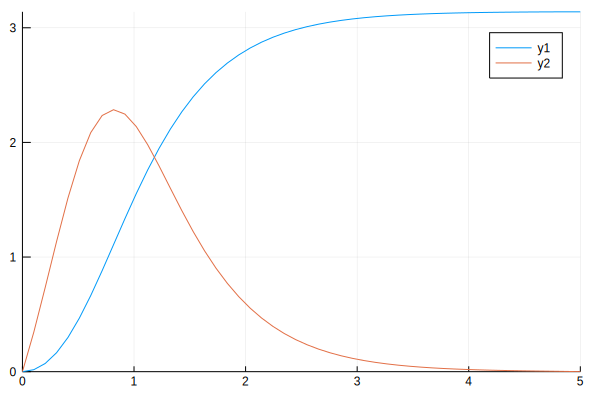

In [11]:
P = plot(linspace(0,tf,size(X,2)),X[1,:])
P = plot!(linspace(0,tf,size(X,2)),X[2,:])

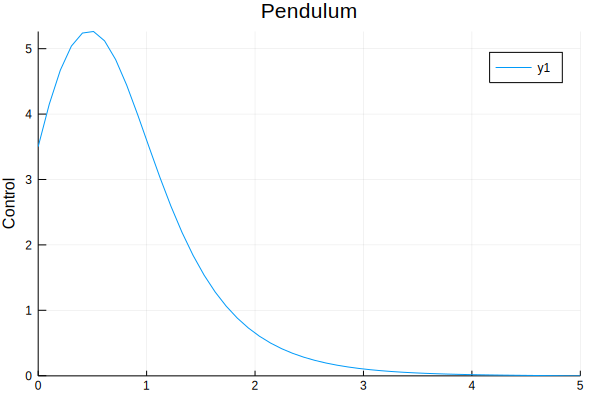

In [12]:
W = plot(linspace(0,tf,size(X,2)),[U[1,:]; U[1,end]],title="Pendulum",ylabel="Control")

In [13]:
plt = plot()
@gif for i=1:size(X,2)
    x = cos(X[1,i] - pi/2)
    y = sin(X[1,i] - pi/2)
    plt = plot([0,x],[0,y],xlims=(-1.5,1.5),ylims=(-1.5,1.5),color="black",size=(200,200),label="",title="Pendulum")
end 

INFO: Saved animation to C:\Users\taylor howell\Google Drive\Stanford\Research-Manchester\iLQR demos\tmp.gif


Plots.AnimatedGif("C:\\Users\\taylor howell\\Google Drive\\Stanford\\Research-Manchester\\iLQR demos\\tmp.gif")